# Neuroevolution

Today we are going to experiment with neuroevolution and see how to implement simple neuroevolutionary algorithms. We will start by implementing a simple weight evolution, then we will also try NEAT.

The evolution of only weights is very simple, we just need to implement a simple neural network with a method to set the weigths from a vector. Then we evolve an individual that contains only this vector. During the evaluation, we set the network weigths according to the individual and evaluate it. In this way, we try to implement classification on the well-known iris problem.

In [7]:
from sklearn import datasets, model_selection
import numpy as np

# read the data and divide them into training and testing sets
iris = datasets.load_iris()
train_x, test_x, train_y, test_y = model_selection.train_test_split(iris.data, iris.target)

import collections

# prepare a simple implementation of a neural network
class NeuralNetwork:

    def __init__(self, layer_sizes, activations):
        self.layer_sizes = layer_sizes
        self.layers = None

        if isinstance(activations, list):
            if len(list(activations)) != len(layer_sizes) - 1:
                raise AttributeError("Number of activations does not match number of layers")
            self.activations = list(activations)
        else:
            self.activations = [activations] * (len(layer_sizes) - 1)

        self.vectorized_net = None

    # number of network parameters
    def vectorized_size(self):
        return sum(map(lambda x: (x[0] + 1) * x[1], zip(self.layer_sizes, self.layer_sizes[1:])))

    # set the parameters based on a vector
    def set_weights(self, vectorized_net):

        if len(vectorized_net) != self.vectorized_size():
            raise AttributeError(
                f"Length of vector does not match vectorized_size: {len(vectorized_net)} != {self.vectorized_size()}")

        self.vectorized_net = vectorized_net

        self.layers = []

        sum_sizes = 0
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            layer = vectorized_net[sum_sizes: sum_sizes + (p + 1) * n]
            self.layers.append(np.reshape(layer, newshape=(p + 1, n)))
            sum_sizes += (p + 1) * n

    def eval_network(self, inputs):

        activations = inputs
        try:
            for act_func, layer in zip(self.activations, self.layers):
                activations_1 = np.append(np.array([1.0]), activations)  # add constant 1.0 for the bias term
                activations = act_func(np.dot(activations_1, layer))
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations

We use the CMA-ES algorithm for setting the weights of the neural network. CMA-ES is an evolutionary strategy that adapts the entire covariance matrix of a multinomial normal distribution. It is implemented in the deap library we have already seen and it is easy to use.

In [8]:
def relu(x):
    return np.maximum(0,x)

def linear(x):
    return x

net = NeuralNetwork([4, 5, 3], [relu, linear])
ind_size = net.vectorized_size()

def fitness(ind, X, y):
    net.set_weights(ind)
    
    acc = 0
    for xi, yi in zip(X, y):
        if np.argmax(net.eval_network(xi)) == yi:
            acc += 1
    
    return acc/len(y),
        
from deap import algorithms, creator, base, benchmarks, cma, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("evaluate", fitness, X=train_x, y=train_y)

strategy = cma.Strategy(centroid=[0.0]*ind_size, sigma=0.1, lambda_=5*ind_size)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

_ = algorithms.eaGenerateUpdate(toolbox, ngen=75, stats=stats, halloffame=hof)

/home/gabi/data/Gabi/envs/pyt/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/gabi/data/Gabi/envs/pyt/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	std      	min	max   
0  	215   	0.334095	0.0968635	0  	0.6875
1  	215   	0.33858 	0.100296 	0  	0.678571
2  	215   	0.347841	0.0796844	0  	0.678571
3  	215   	0.35353 	0.0883753	0  	0.678571
4  	215   	0.344767	0.106304 	0  	0.678571
5  	215   	0.356271	0.077194 	0  	0.678571
6  	215   	0.351121	0.0877509	0  	0.678571
7  	215   	0.356354	0.0869404	0  	0.75    
8  	215   	0.371221	0.108108 	0.00892857	0.678571
9  	215   	0.375623	0.101199 	0.0357143 	0.678571
10 	215   	0.362625	0.111126 	0.00892857	0.6875  
11 	215   	0.386752	0.128089 	0         	0.982143
12 	215   	0.407724	0.135993 	0         	0.928571
13 	215   	0.411254	0.135895 	0         	0.75    
14 	215   	0.435839	0.144453 	0.0446429 	0.678571
15 	215   	0.419601	0.146417 	0         	0.866071
16 	215   	0.427035	0.151741 	0.00892857	0.910714
17 	215   	0.464659	0.154588 	0.0178571 	0.678571
18 	215   	0.461462	0.156938 	0.232143  	0.964286
19 	215   	0.463331	0.159954 	0.125     	0.866071
20 	215   	0.4747

We will evaluate the accuracy on the testing data.

In [9]:
fitness(hof[0], test_x, test_y)

(1.0,)

# NEAT

The NEAT algorithms is implemented in the `neat-python` library. The library has a slightly different interface than what we are used to, but it is not difficult to learn how to use it. The algorithm settings are loaded from a file, and then we just run the algorithm. Below we show an example from the `neat-python` documentation modified for iris classification.

For the visualization of the network, you will need to install the `python-graphviz` package.


 ****** Running generation 0 ****** 

Population's average fitness: 37.10667 stdev: 13.56277
Best fitness: 76.00000 - size: (3, 12) - species 1 - id 82
Average adjusted fitness: 0.488
Mean genetic distance 1.109, standard deviation 0.272
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150     76.0    0.488     0
Total extinctions: 0
Generation time: 0.171 sec

 ****** Running generation 1 ****** 

Population's average fitness: 39.82667 stdev: 14.20223
Best fitness: 76.00000 - size: (3, 12) - species 1 - id 82
Average adjusted fitness: 0.524
Mean genetic distance 1.253, standard deviation 0.298
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150     76.0    0.524     1
Total extinctions: 0
Generation time: 0.161 sec (0.166 average)

 ****** Running generation 2 ****** 

Population's average fitness: 42.74667 

Population's average fitness: 56.23333 stdev: 18.90905
Best fitness: 105.00000 - size: (3, 8) - species 1 - id 1015
Average adjusted fitness: 0.481
Mean genetic distance 1.569, standard deviation 0.447
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18   150    105.0    0.481    12
Total extinctions: 0
Generation time: 0.153 sec (0.154 average)

 ****** Running generation 19 ****** 

Population's average fitness: 60.23333 stdev: 17.94934
Best fitness: 105.00000 - size: (3, 8) - species 1 - id 1015
Average adjusted fitness: 0.508
Mean genetic distance 1.586, standard deviation 0.509
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19   150    105.0    0.508    13
Total extinctions: 0
Generation time: 0.153 sec (0.154 average)
Saving checkpoint to neat-checkpoint-19

 ****** Running generation 20 ****** 

Population's ave

Population's average fitness: 58.03333 stdev: 18.98997
Best fitness: 108.00000 - size: (3, 6) - species 1 - id 3057
Average adjusted fitness: 0.306
Mean genetic distance 1.490, standard deviation 0.376
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   36   150    108.0    0.306    16
Total extinctions: 0
Generation time: 0.142 sec (0.143 average)

 ****** Running generation 37 ****** 

Population's average fitness: 60.23333 stdev: 19.73978
Best fitness: 108.00000 - size: (3, 6) - species 1 - id 3057
Average adjusted fitness: 0.388
Mean genetic distance 1.305, standard deviation 0.382
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   37   150    108.0    0.388    17
Total extinctions: 0
Generation time: 0.131 sec (0.142 average)

 ****** Running generation 38 ****** 

Population's average fitness: 57.23333 stdev: 18.79731
B

Population's average fitness: 59.34000 stdev: 19.78377
Best fitness: 109.00000 - size: (3, 6) - species 1 - id 6852
Average adjusted fitness: 0.540
Mean genetic distance 1.727, standard deviation 0.444
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   54   150    109.0    0.540     8
Total extinctions: 0
Generation time: 0.148 sec (0.144 average)
Saving checkpoint to neat-checkpoint-54

 ****** Running generation 55 ****** 

Population's average fitness: 59.98000 stdev: 19.29127
Best fitness: 109.00000 - size: (3, 6) - species 1 - id 6852
Average adjusted fitness: 0.449
Mean genetic distance 2.264, standard deviation 0.720
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   55   130    109.0    0.449     9
     2    0    20       --       --     0
Total extinctions: 0
Generation time: 0.146 sec (0.144 average)

 ****** Runni

Population's average fitness: 63.73510 stdev: 21.07247
Best fitness: 109.00000 - size: (3, 6) - species 1 - id 6852
Average adjusted fitness: 0.378
Mean genetic distance 2.208, standard deviation 0.700
Population of 149 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   71    45    109.0    0.322    25
     2   16    55    106.0    0.438    12
     3   14    49    107.0    0.374    10
Total extinctions: 0
Generation time: 0.148 sec (0.153 average)

 ****** Running generation 72 ****** 

Population's average fitness: 64.42953 stdev: 21.39882
Best fitness: 109.00000 - size: (3, 6) - species 1 - id 6852
Average adjusted fitness: 0.591
Mean genetic distance 2.180, standard deviation 0.667
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   72    48    109.0    0.577    26
     2   17    52    106.0    0.573    13
     3   15    50    107.0    0.62

Population's average fitness: 62.78000 stdev: 20.73318
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.362
Mean genetic distance 2.234, standard deviation 0.826
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   88    81    110.0    0.360     0
     3   31    69    108.0    0.365    14
Total extinctions: 0
Generation time: 0.144 sec (0.149 average)

 ****** Running generation 89 ****** 

Population's average fitness: 61.62000 stdev: 20.76204
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.498
Mean genetic distance 2.186, standard deviation 0.779
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   89    78    110.0    0.479     1
     3   32    72    108.0    0.516    15
Total extinctions: 0
Generation time: 0.141 sec (0.146 average)
Saving che

Population's average fitness: 65.33113 stdev: 20.88496
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.395
Mean genetic distance 2.065, standard deviation 0.642
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  103    42    110.0    0.355    15
     3   46    48    108.0    0.414    29
     4   10    60    106.0    0.414     9
Total extinctions: 0
Generation time: 0.152 sec (0.147 average)

 ****** Running generation 104 ****** 

Population's average fitness: 65.98667 stdev: 21.95996
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.399
Mean genetic distance 2.083, standard deviation 0.691
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  104    39    110.0    0.348    16
     3   47    50    108.0    0.392    30
     4   11    62    106.0    0

Population's average fitness: 63.57333 stdev: 20.98995
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.375
Mean genetic distance 2.029, standard deviation 0.691
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  118    75    110.0    0.400    30
     3   61    75    108.0    0.349    44
Total extinctions: 0
Generation time: 0.144 sec (0.152 average)

 ****** Running generation 119 ****** 

Population's average fitness: 66.33333 stdev: 20.78418
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.410
Mean genetic distance 2.083, standard deviation 0.667
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  119    79    110.0    0.437    31
     3   62    71    108.0    0.383    45
Total extinctions: 0
Generation time: 0.148 sec (0.151 average)
Saving ch

Population's average fitness: 63.07333 stdev: 20.57413
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.569
Mean genetic distance 2.011, standard deviation 0.800
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  135    76    110.0    0.556    47
     3   78    74    108.0    0.583    61
Total extinctions: 0
Generation time: 0.172 sec (0.150 average)

 ****** Running generation 136 ****** 

Population's average fitness: 66.55333 stdev: 20.51911
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.413
Mean genetic distance 2.012, standard deviation 0.723
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  136    78    110.0    0.392    48
     3   79    72    108.0    0.434    62
Total extinctions: 0
Generation time: 0.148 sec (0.151 average)

 ****** 

Population's average fitness: 62.70000 stdev: 21.62429
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.362
Mean genetic distance 2.065, standard deviation 0.729
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  151    73    110.0    0.335    63
     3   94    77    108.0    0.388    77
Total extinctions: 0
Generation time: 0.141 sec (0.146 average)

 ****** Running generation 152 ****** 

Population's average fitness: 61.19333 stdev: 20.38421
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.340
Mean genetic distance 2.033, standard deviation 0.696
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  152    71    110.0    0.311    64
     3   95    79    108.0    0.368    78
Total extinctions: 0
Generation time: 0.151 sec (0.147 average)

 ****** 

Population's average fitness: 62.83333 stdev: 21.21208
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.395
Mean genetic distance 2.108, standard deviation 0.784
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  169    79    110.0    0.397    81
     3  112    71    108.0    0.394    95
Total extinctions: 0
Generation time: 0.150 sec (0.147 average)
Saving checkpoint to neat-checkpoint-169

 ****** Running generation 170 ****** 

Population's average fitness: 63.25333 stdev: 21.30890
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.370
Mean genetic distance 2.015, standard deviation 0.758
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  170    75    110.0    0.341    82
     3  113    75    108.0    0.399    96
Total extinctions: 0
Generation 

Population's average fitness: 62.12000 stdev: 20.89591
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.318
Mean genetic distance 2.514, standard deviation 0.767
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  186    67    110.0    0.346    98
     3  129    46    108.0    0.364   112
     5    1    37     72.0    0.243     0
Total extinctions: 0
Generation time: 0.171 sec (0.146 average)

 ****** Running generation 187 ****** 

Population's average fitness: 60.74667 stdev: 22.32851
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.333
Mean genetic distance 2.460, standard deviation 0.703
Population of 149 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  187    58    110.0    0.333    99
     3  130    34    108.0    0.352   113
     5    2    57     97.0    0

Population's average fitness: 65.10667 stdev: 21.79179
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.396
Mean genetic distance 2.321, standard deviation 0.853
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  204    77    110.0    0.333   116
     5   19    73    109.0    0.459    15
Total extinctions: 0
Generation time: 0.141 sec (0.140 average)
Saving checkpoint to neat-checkpoint-204

 ****** Running generation 205 ****** 

Population's average fitness: 62.53333 stdev: 20.67064
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.535
Mean genetic distance 2.335, standard deviation 0.891
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  205    77    110.0    0.523   117
     5   20    73    109.0    0.547    16
Total extinctions: 0
Generation 

Population's average fitness: 57.56000 stdev: 19.52348
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.277
Mean genetic distance 2.855, standard deviation 0.988
Population of 149 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  219    54    110.0    0.400   131
     5   34    42    109.0    0.272    30
     6    8    25     98.0    0.244     0
     7    5    28     72.0    0.193     3
Total extinctions: 0
Generation time: 0.145 sec (0.151 average)
Saving checkpoint to neat-checkpoint-219

 ****** Running generation 220 ****** 

Population's average fitness: 61.65101 stdev: 20.92971
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.338
Mean genetic distance 2.798, standard deviation 0.988
Population of 149 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  220    46    110.0    0.

Population's average fitness: 65.29333 stdev: 20.80594
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.389
Mean genetic distance 2.608, standard deviation 0.950
Population of 150 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  233    40    110.0    0.384   145
     5   48    39    109.0    0.466    44
     6   22    35    106.0    0.456    11
     7   19    36     95.0    0.248     9
Total extinctions: 0
Generation time: 0.149 sec (0.140 average)

 ****** Running generation 234 ****** 

Population's average fitness: 62.91333 stdev: 22.79735
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.524
Mean genetic distance 2.630, standard deviation 1.008
Population of 151 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  234    43    110.0    0.537   146
     5   49    36    109.0    0

Population's average fitness: 61.36242 stdev: 21.55350
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.341
Mean genetic distance 2.473, standard deviation 0.846
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  249    54    110.0    0.365   161
     5   64    52    109.0    0.412    60
     7   35    45    106.0    0.246    10
Total extinctions: 0
Generation time: 0.151 sec (0.147 average)
Saving checkpoint to neat-checkpoint-249

 ****** Running generation 250 ****** 

Population's average fitness: 61.49669 stdev: 20.23435
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.343
Mean genetic distance 2.624, standard deviation 0.874
Population of 149 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  250    61    110.0    0.375   162
     5   65    51    109.0    0.

Population's average fitness: 63.29333 stdev: 23.28907
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.578
Mean genetic distance 2.224, standard deviation 0.964
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  266    77    110.0    0.559   178
     5   81    73    109.0    0.596    77
Total extinctions: 0
Generation time: 0.136 sec (0.142 average)

 ****** Running generation 267 ****** 

Population's average fitness: 63.46000 stdev: 21.07435
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.372
Mean genetic distance 2.254, standard deviation 0.981
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  267    79    110.0    0.341   179
     5   82    71    109.0    0.403    78
Total extinctions: 0
Generation time: 0.146 sec (0.142 average)

 ****** 

Population's average fitness: 60.90667 stdev: 21.56860
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.323
Mean genetic distance 2.563, standard deviation 0.981
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  283    61    110.0    0.268   195
     5   98    65    109.0    0.402    94
     8    1    25     79.0    0.301     0
Total extinctions: 0
Generation time: 0.134 sec (0.142 average)

 ****** Running generation 284 ****** 

Population's average fitness: 63.78146 stdev: 20.26771
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.366
Mean genetic distance 2.574, standard deviation 0.930
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  284    61    110.0    0.325   196
     5   99    60    109.0    0.439    95
     8    2    30     79.0    0

Population's average fitness: 64.06711 stdev: 21.50906
Best fitness: 110.00000 - size: (3, 6) - species 1 - id 12994
Average adjusted fitness: 0.484
Mean genetic distance 2.306, standard deviation 0.860
Population of 150 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  297    30    110.0    0.520   209
     5  112    37    109.0    0.499   108
     8   15    31    104.0    0.464     2
     9   11    52    104.0    0.455     9
Total extinctions: 0
Generation time: 0.140 sec (0.144 average)

 ****** Running generation 298 ****** 

Population's average fitness: 66.84000 stdev: 22.20753
Best fitness: 110.00000 - size: (3, 6) - species 9 - id 12994

Species 5 with 37 members is stagnated: removing it
Average adjusted fitness: 0.555
Mean genetic distance 2.016, standard deviation 0.782
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  298    48   

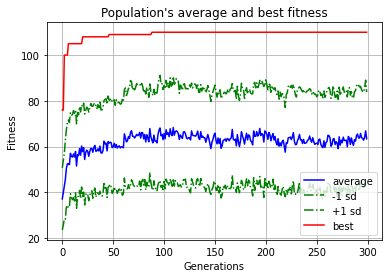

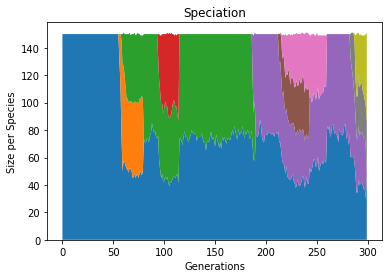

Mean genetic distance 1.410, standard deviation 0.312
Mean genetic distance 1.607, standard deviation 0.291
Mean genetic distance 1.571, standard deviation 0.313
Mean genetic distance 1.507, standard deviation 0.355
Mean genetic distance 1.702, standard deviation 0.348
Mean genetic distance 1.603, standard deviation 0.360
Mean genetic distance 1.488, standard deviation 0.338
Mean genetic distance 1.604, standard deviation 0.392
Mean genetic distance 1.572, standard deviation 0.411
Mean genetic distance 1.639, standard deviation 0.365


In [10]:
import os
import neat
import visualize

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(train_x, train_y):
            output = net.activate(xi)
            genome.fitness += 1 if np.argmax(output) == xo else 0


def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 300)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(train_x, train_y):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    node_names = {-1:'x1', -2: 'x2', -3: 'x3', -4: 'x4', 0:'setosa', 1:'virginica', 2:'versicolor'}
    visualize.draw_net(config, winner, True, node_names=node_names)
    visualize.plot_stats(stats, ylog=False, view=True)
    visualize.plot_species(stats, view=True)

    p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    p.run(eval_genomes, 10)


if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    config_path = os.path.join('.', 'config-feedforward')
    run(config_path)